In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
origin_data = pd.read_csv("lending_club_2020_train.csv")
origin_data.head() 

C:\Users\Na\AppData\Local\Temp\ipykernel_47484\4061970510.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  origin_data = pd.read_csv("lending_club_2020_train.csv")


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,124989905,6000.0,6000.0,6000.0,36 months,7.97%,187.94,A,A5,Teacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,139665484,35000.0,35000.0,35000.0,60 months,14.47%,822.95,C,C2,Product Specialist,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,84253847,23200.0,23200.0,23200.0,60 months,24.99%,680.82,E,E4,Production Foreman,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y
3,126296074,4500.0,4500.0,4500.0,36 months,9.93%,145.06,B,B2,Office Manager,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,148913312,15000.0,15000.0,15000.0,36 months,16.40%,530.33,C,C4,Secretary,...,May-2020,Jul-2020,May-2020,2.0,0.0,ACTIVE,413.83,11025.25,54.62,N


In [9]:
# drop할 컬럼들을 일단 처리한다.
with open('drop_columns.txt', mode='r') as f:
    drop_fields = f.readlines()
    drop_fields = [drop_field.strip('\n') for drop_field in drop_fields]

In [10]:
drop_df = origin_data.drop(columns=drop_fields)

In [11]:
len(drop_df.columns)

79

In [12]:
drop_df['loan_status'].value_counts()

loan_status
Fully Paid                                             898522
Current                                                618688
Charged Off                                            217366
Late (31-120 days)                                       9840
In Grace Period                                          6049
Late (16-30 days)                                        1620
Issued                                                   1258
Does not meet the credit policy. Status:Fully Paid       1223
Does not meet the credit policy. Status:Charged Off       460
Default                                                   268
Name: count, dtype: int64

In [13]:
modified_df = drop_df[~drop_df['loan_status'].isin(['Current', 'Issued', 'Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off'])]

In [14]:
modified_df.loc[modified_df['loan_status'].isin(['Fully Paid', 'In Grace Period']), 'loan_status'] = 0
modified_df.loc[modified_df['loan_status'].isin(['Charged Off', 'Default', 'Late (16-30 days)', 'Late (31-120 days)']), 'loan_status'] = 1

In [15]:
len(modified_df)

1133666

In [16]:
len(modified_df.duplicated())

1133666

In [17]:
# term : 36 months -> 36 으로 변환해줘야한다.
# modified_df['term'] = modified_df['term'].astype(str).apply(delete_suffix)

# 이 함수는 쓸 일 없어짐(int_rate 필드 drop함)
# modified_df['int_rate'] = modified_df['int_rate'].astype(str).apply(delete_suffix_percentage)

# modified_df['revol_util'] = modified_df['revol_util'].astype(str).apply(delete_suffix_percentage)

# zip_code : 554xx -> 554로 변환해줘야한다.
# modified_df['zip_code'] = modified_df['zip_code'].astype(str).apply(delete_suffix_xx)


# columns_to_modify = ['earliest_cr_line','last_pymnt_d','next_pymnt_d',
#                      'last_credit_pull_d','sec_app_earliest_cr_line',
#                      'hardship_start_date','hardship_end_date',
#                      'payment_plan_start_date', 'issue_d']
# apply_to_multiple_columns(columns_to_modify)

def delete_suffix(term:str)->int:
    '''첫 단어만을 저장하는 함수'''
    term = term.strip().split()[0]
    return int(term)

def delete_suffix_percentage(term:str)->float:
    '''%를 자르는 함수'''
    term = term.strip('%')
    return float(term)

def delete_suffix_xx(term:str)->int:
    '''xx를 자르는 함수'''
    term = term.strip('xx')
    return int(term)

def apply_to_multiple_columns(date_columns:list)->None:
    '''modified_df에서 %b-%Y(Aug-2006) 형식의 날짜 정보를 %Y-%m-%d(2006-08-01)형태로 저장하는 함수'''
    for col in date_columns:
        modified_df[col]=pd.to_datetime(modified_df[col], format='%b-%Y')

In [18]:
modified_df.select_dtypes('object').columns

Index(['term', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'loan_status', 'purpose', 'addr_state',
       'revol_util', 'application_type'],
      dtype='object')

In [19]:
THRESHOLD = 50
#THRESHOLD를 어떻게 자르느냐에 따라 NA processing 기준점 달라짐. 

null_percentages = (modified_df.isnull().sum() * 100) / len(modified_df)
columns_to_drop = null_percentages[null_percentages >= THRESHOLD].index
columns_to_keep = null_percentages[null_percentages < THRESHOLD].index
# 필드 추출
filtered_df = modified_df[columns_to_keep]
filtered_df.columns
columns_to_drop

Index(['mths_since_last_delinq', 'mths_since_last_record',
       'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
       'revol_bal_joint'],
      dtype='object')

In [20]:
filtered_df.select_dtypes('object').columns

Index(['term', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'loan_status', 'purpose', 'addr_state',
       'revol_util', 'application_type'],
      dtype='object')

In [21]:
filtered_df.shape

(1133666, 71)

In [22]:
filtered_df.dropna(how='all')

,loan_amnt,term,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,6000.0,36 months,A5,2 years,MORTGAGE,45000.0,Verified,0,debt_consolidation,MN,...,0.0,4.0,97.1,0.0,0.0,0.0,78611.0,50054.0,15000.0,56511.0
2,23200.0,60 months,E4,10+ years,MORTGAGE,110000.0,Verified,1,debt_consolidation,OK,...,0.0,5.0,94.8,37.5,0.0,0.0,650914.0,294461.0,20300.0,291465.0
5,16000.0,36 months,A2,NaN,MORTGAGE,65000.0,Not Verified,1,home_improvement,TX,...,0.0,1.0,100.0,0.0,0.0,0.0,196139.0,32551.0,59100.0,49339.0
6,4500.0,36 months,B3,5 years,MORTGAGE,50000.0,Not Verified,0,home_improvement,FL,...,0.0,1.0,77.8,33.3,2.0,0.0,211837.0,9573.0,9300.0,11970.0
7,20000.0,36 months,B3,10+ years,MORTGAGE,60000.0,Source Verified,0,credit_card,IL,...,0.0,2.0,77.5,100.0,0.0,0.0,186765.0,66283.0,11000.0,73090.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1755288,26500.0,60 months,C5,2 years,MORTGAGE,60000.0,Verified,0,debt_consolidation,MN,...,0.0,2.0,100.0,100.0,0.0,0.0,258273.0,34014.0,18900.0,16784.0
1755290,3600.0,36 months,E1,7 years,MORTGAGE,33800.0,Not Verified,1,debt_consolidation,TX,...,0.0,2.0,100.0,100.0,0.0,0.0,87427.0,11973.0,6500.0,13375.0
1755291,19000.0,36 months,A3,4 years,MORTGAGE,71000.0,Not Verified,0,debt_consolidation,UT,...,0.0,2.0,96.9,0.0,0.0,0.0,281551.0,50883.0,17600.0,43550.0
1755292,9600.0,36 months,C1,9 years,MORTGAGE,44000.0,Verified,0,debt_consolidation,TX,...,0.0,2.0,100.0,100.0,0.0,0.0,151287.0,13537.0,4200.0,10414.0


In [23]:
filtered_df.shape

(1133666, 71)

# Processing

In [ ]:
def check_field(column_name:str)->None:
    print("==============isna")
    print(filtered_df[column_name].isna().sum()*100/len(filtered_df[column_name]), '%')
    print("==============head")
    print(filtered_df[column_name].head())
    print("==============value_count")
    print(filtered_df[column_name].value_counts())

이거 코드 위에서부터 na비율이랑, head 데이터, value_count 실행한거 그냥 함수화한 거고

In [ ]:
target_column = 'num_rev_tl_bal_gt_0'
#target_column값에 따라 컬럼명 입력하면 해당 필드 값들에서 loan_status가 정상적인 상황(0 : fully paid, in grace,,,) 값 비율 확인할 수 있는 plot입니다.
column_values = filtered_df[target_column].unique()
column_values = column_values[~pd.isna(column_values)]
column_values.sort()
print(column_values)
x = []
y =[]
for value in column_values:
    pos_percent = len(filtered_df[(filtered_df[target_column]==value) & (filtered_df['loan_status']==0)])*100/len(filtered_df[filtered_df[target_column]==value])
    print(value)
    print(pos_percent)
    x.append(value)
    y.append(pos_percent)

print("na")
print(len(filtered_df[(filtered_df[target_column].isna()) & (filtered_df['loan_status']==0)])*100/len(filtered_df[filtered_df[target_column].isna()]))
plt.plot(x, y)

In [ ]:
def plot_col(filtered_df, target_column):
  """
    target_column의 값 별 비율를 시각화하는 함수

    arguments:
      filtered_df : 데이터프레임
      target_column : filtered_df에서 시각화할 변수
    result:
      barplot 시각화
  """
  column_values = filtered_df[target_column].unique()
  column_values = column_values[~pd.isna(column_values)]
  column_values.sort()
  print("unique column values", column_values)
  print("the number of unique values", len(column_values))

  x = []
  y = []
  for value in column_values:
      pos_percent = len(filtered_df[(filtered_df[target_column]==value) & (filtered_df['loan_status']==0)])*100/len(filtered_df[filtered_df[target_column]==value])
      print("value : ", value, ", \t pos_percent : ", round(pos_percent,4))
      x.append(value)
      y.append(pos_percent)

  print("num of na", len(filtered_df[(filtered_df[target_column].isna()) & (filtered_df['loan_status']==0)])*100/len(filtered_df[filtered_df[target_column].isna()]))
  plt.bar(x, y)
  plt.show()

In [ ]:
def extract_NaN(str, df) :
    s1 = df[str]
    print(s1.isna().sum())
    return df[s1.isna()][str, 'issue_d']

In [ ]:
extract_NaN('inq_fi')

In [12]:
origin_data = pd.read_csv("filtered_lending_club_data.csv")
origin_data.head()

,Unnamed: 0,loan_amnt,term,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,0,6000.0,36,A5,2 years,MORTGAGE,45000.0,Verified,0,debt_consolidation,...,0.0,0.0,4.0,97.1,0.0,0.0,78611.0,50054.0,15000.0,56511.0
1,2,23200.0,60,E4,10+ years,MORTGAGE,110000.0,Verified,1,debt_consolidation,...,0.0,0.0,5.0,94.8,37.5,0.0,650914.0,294461.0,20300.0,291465.0
2,5,16000.0,36,A2,NaN,MORTGAGE,65000.0,Not Verified,1,home_improvement,...,0.0,0.0,1.0,100.0,0.0,0.0,196139.0,32551.0,59100.0,49339.0
3,6,4500.0,36,B3,5 years,MORTGAGE,50000.0,Not Verified,0,home_improvement,...,0.0,0.0,1.0,77.8,33.3,2.0,211837.0,9573.0,9300.0,11970.0
4,7,20000.0,36,B3,10+ years,MORTGAGE,60000.0,Source Verified,0,credit_card,...,0.0,0.0,2.0,77.5,100.0,0.0,186765.0,66283.0,11000.0,73090.0


In [13]:
df1 = origin_data[:]

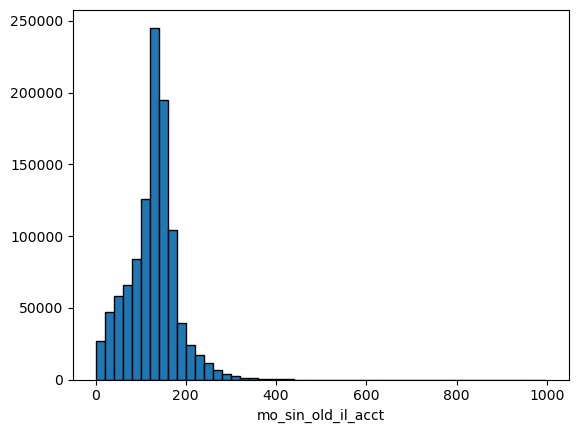

0.0 96.0 129.0 153.0 999.0 125.49595125093003


In [14]:
variable = 'mo_sin_old_il_acct'

plt.hist(df1[variable], bins=50, edgecolor='black')
plt.xlabel('{}'.format(variable))
plt.show()

# NaN 값을 무시하고 계산
maximum = np.nanmax(df1[variable])
minimum = np.nanmin(df1[variable])
q1 = np.nanpercentile(df1[variable], 25)
q2 = np.nanmedian(df1[variable])  # 중앙값
q3 = np.nanpercentile(df1[variable], 75)

mean = np.nanmean(df1[variable])  # NaN 값을 무시하고 평균 계산

print(minimum,q1,q2,q3,maximum,mean)

In [16]:


plt.figure(figsize=(12, 8))
sns.heatmap(df1.corr(), annot=True, cmap='viridis')
plt.show()


ValueError: could not convert string to float: 'A5'

<Figure size 1200x800 with 0 Axes>